<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/tiny_nerf_pytorchipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [2]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
  
  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.
  
  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [5]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [6]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).
  
  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [7]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## NeRF: Network architecture

In [ ]:
class NerfModel(torch.nn.Module):
    def __init__(self, )

## Dataloading utils

In [8]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [9]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2020-08-28 19:44:51--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  53.0MB/s    in 0.2s    

2020-08-28 19:44:51 (53.0 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Determine device to run on (GPU vs CPU)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [11]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")
#data = np.load("/gdrive/My Drive/autonerf.npz")
# Images

images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)
print(tform_cam2world.shape)
# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
#testimg, testpose = images[102], tform_cam2world[102]
#testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images).to(device)

#testimg0 = images[1]
testimg = images[101, ..., :3]
#print(testimg0.shape, testimg.shape)
testpose = tform_cam2world[101]

images = images[:100, ..., :3]


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
torch.Size([106, 4, 4])


#### Display the image used for testing

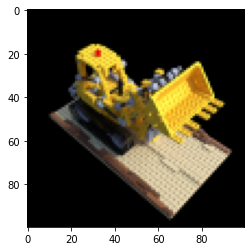

torch.Size([106, 4, 4])


In [34]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

print(tform_cam2world.shape)

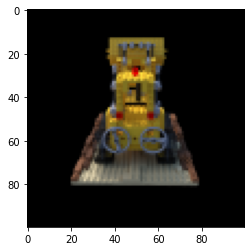

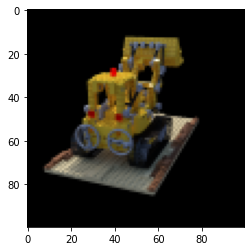

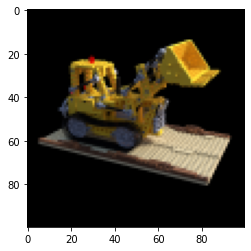

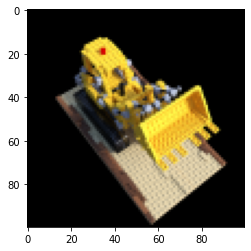

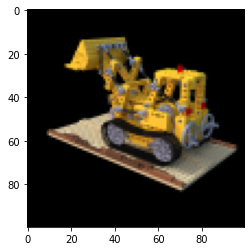

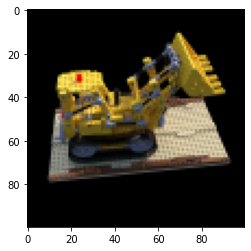

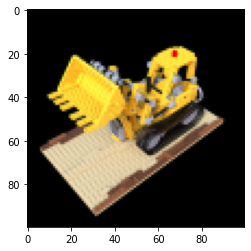

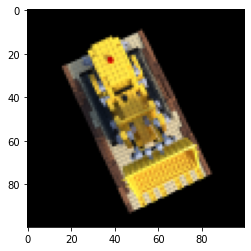

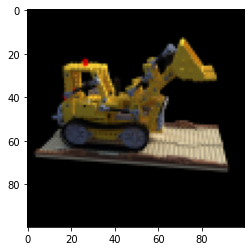

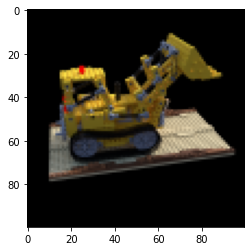

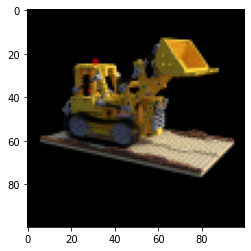

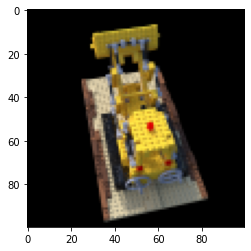

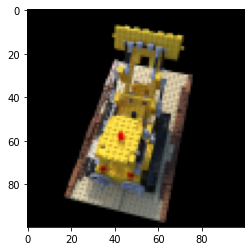

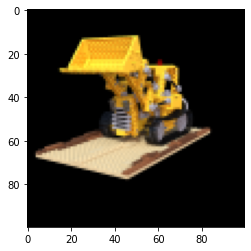

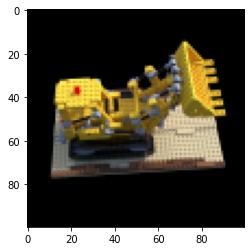

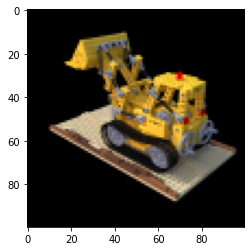

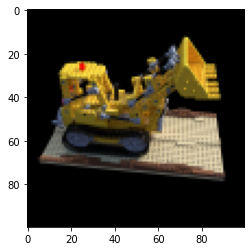

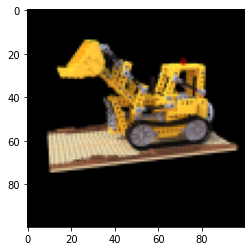

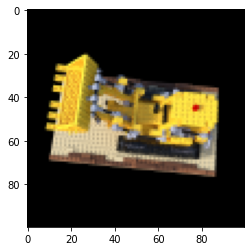

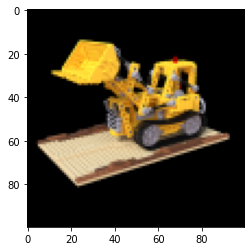

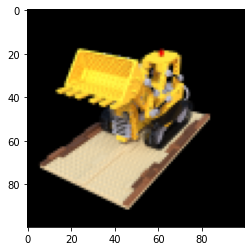

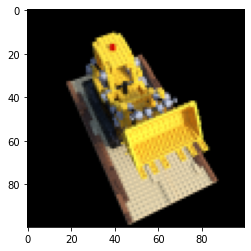

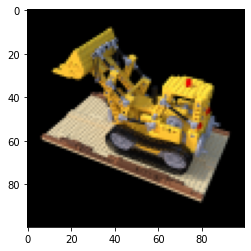

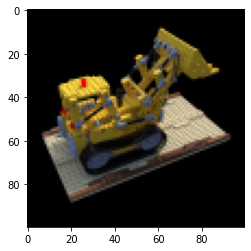

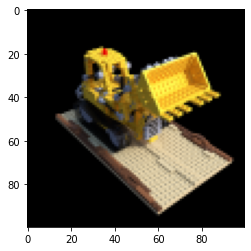

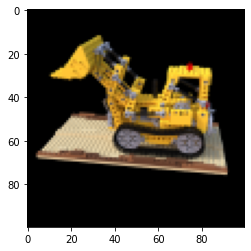

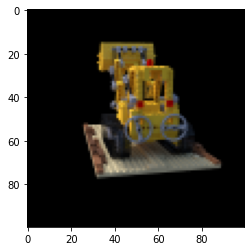

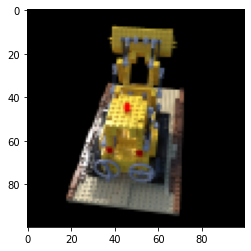

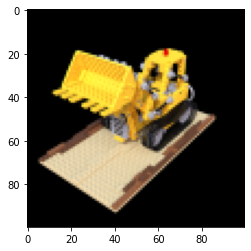

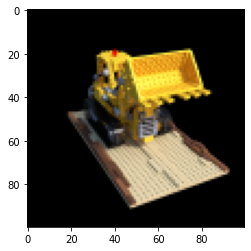

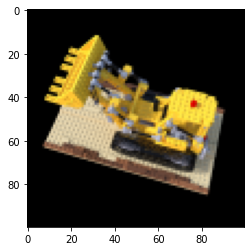

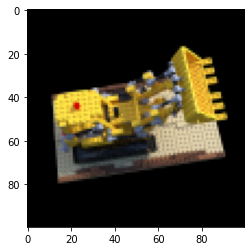

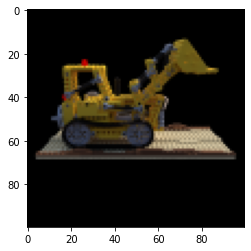

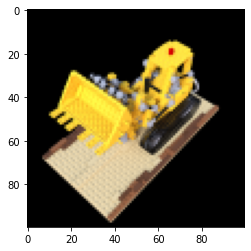

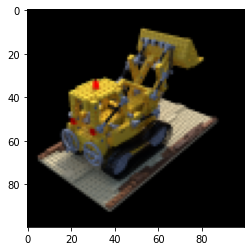

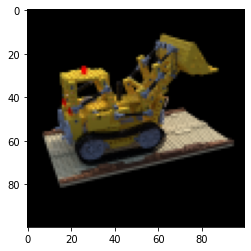

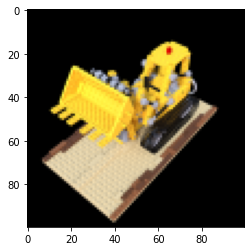

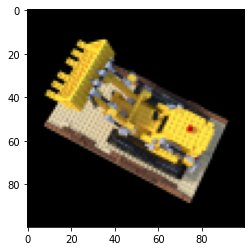

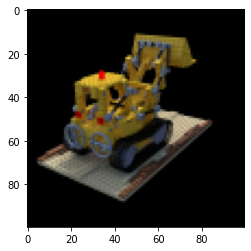

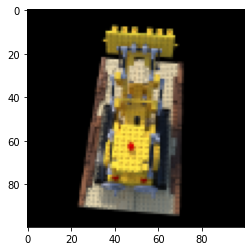

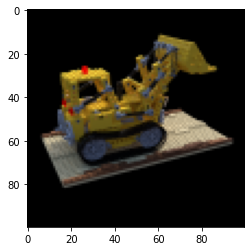

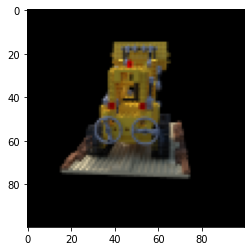

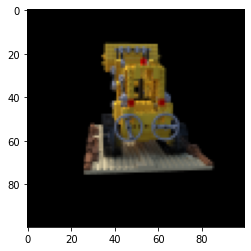

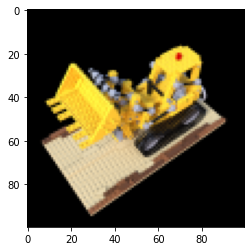

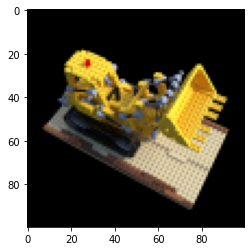

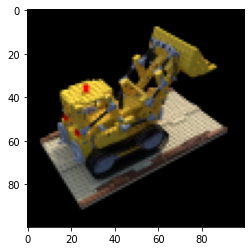

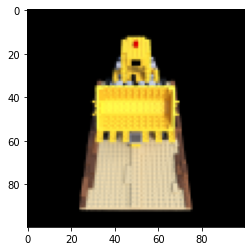

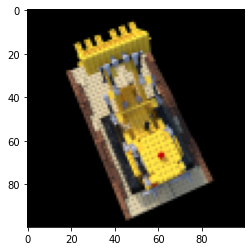

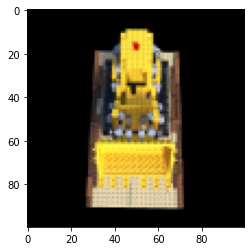

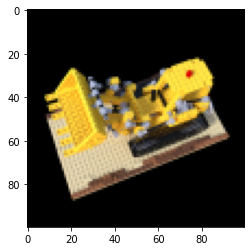

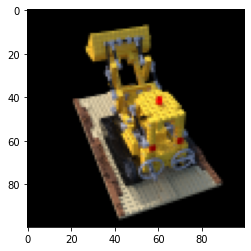

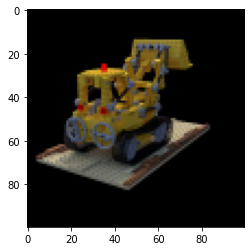

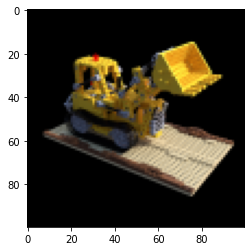

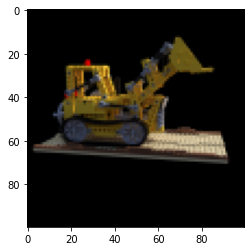

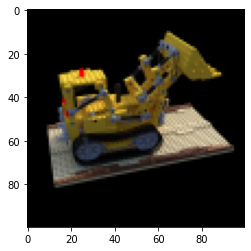

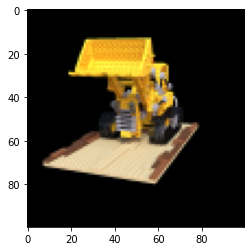

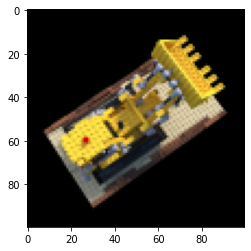

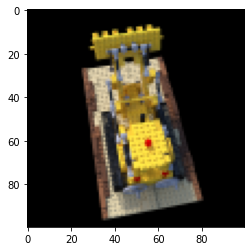

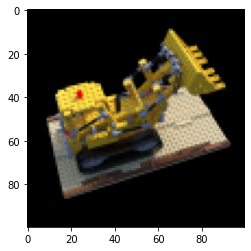

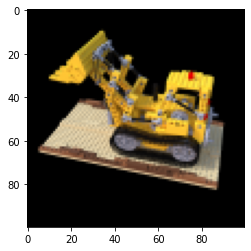

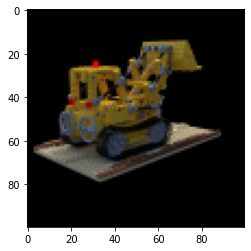

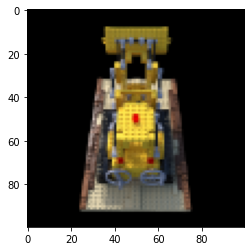

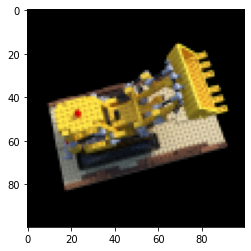

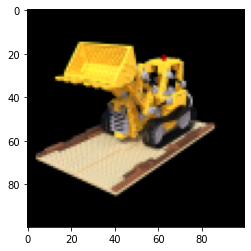

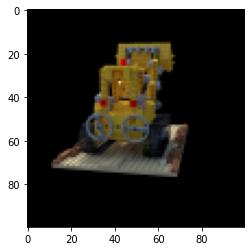

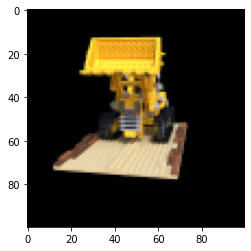

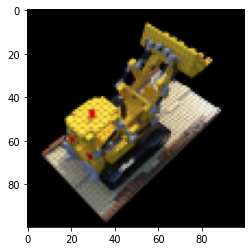

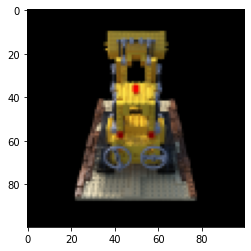

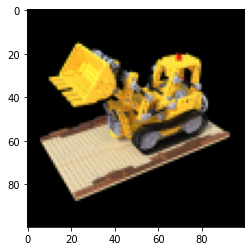

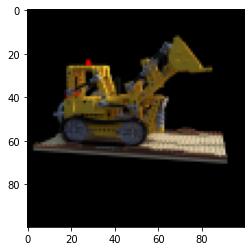

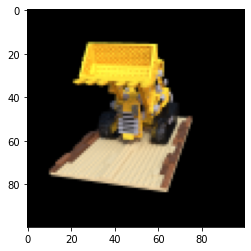

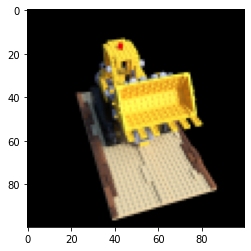

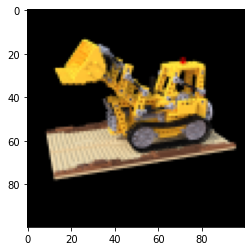

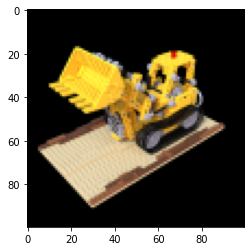

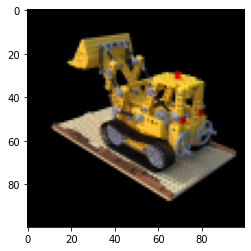

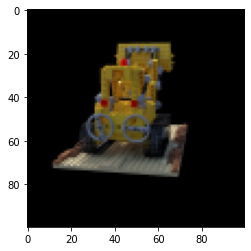

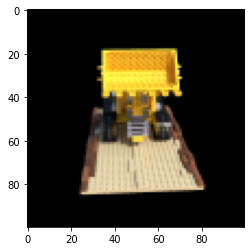

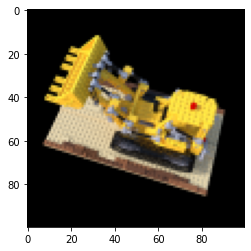

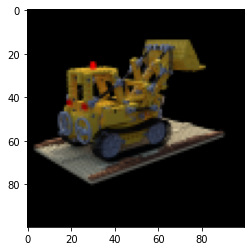

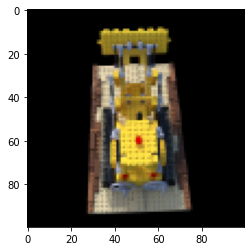

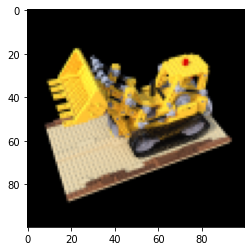

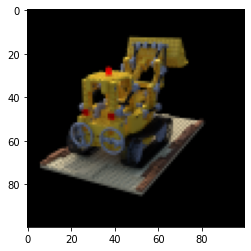

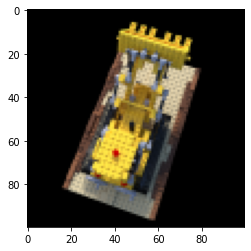

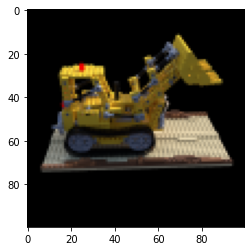

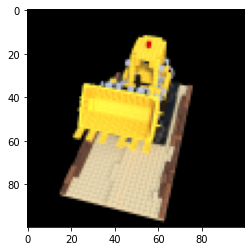

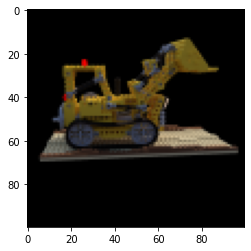

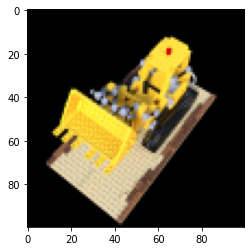

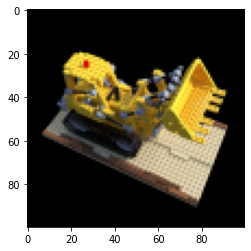

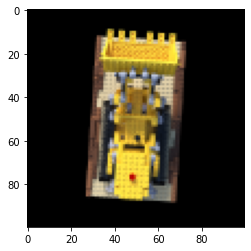

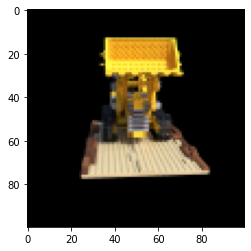

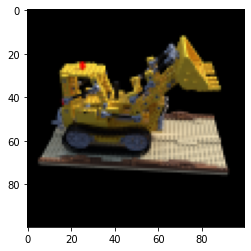

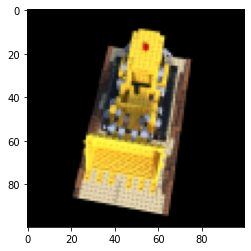

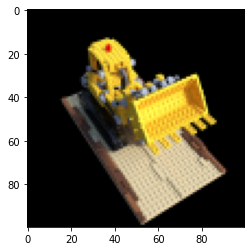

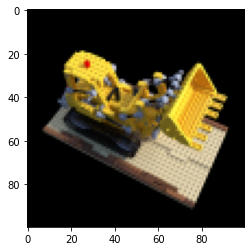

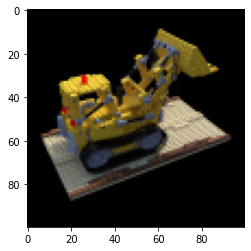

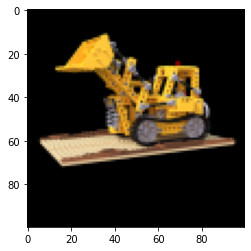

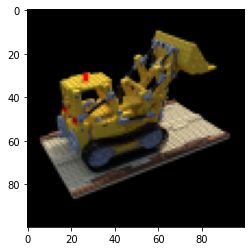

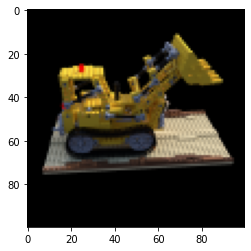

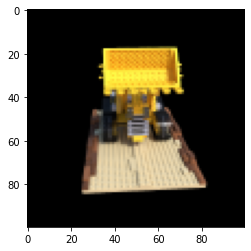

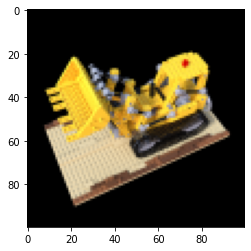

In [14]:
for i in range(0, 100):
    plt.imshow(images[i].detach().cpu().numpy())
    plt.show()

## Train TinyNeRF!

(The cool part!)

In [12]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):
  
  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)
  
  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [16]:
print(focal_length)

tensor(138.8889, device='cuda:0', dtype=torch.float64)


Loss: 0.11598982661962509


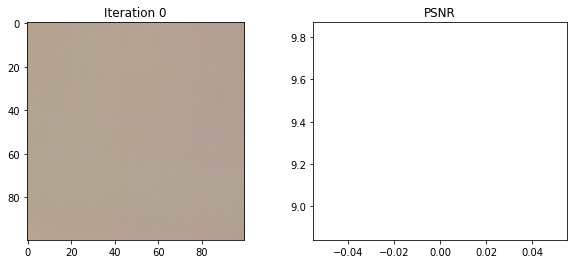

Loss: 0.07606077194213867


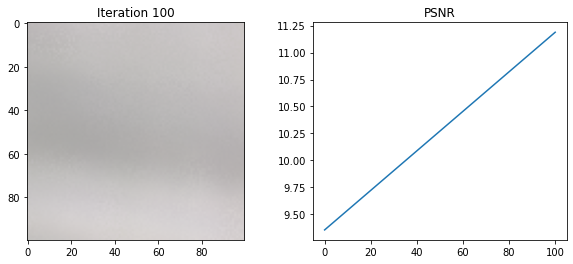

Loss: 0.06231344863772392


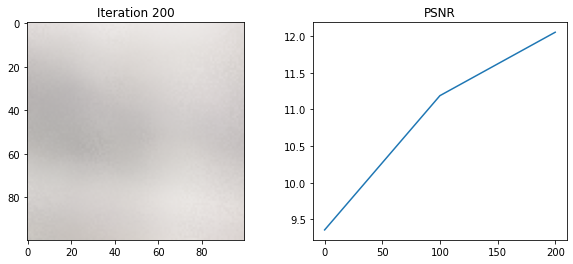

Loss: 0.079130157828331


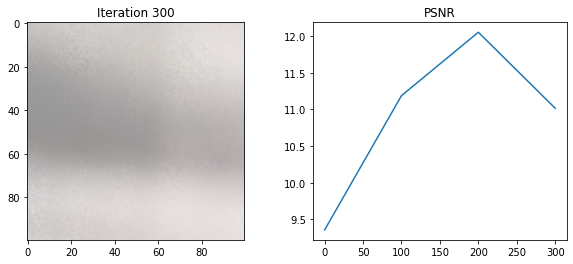

Loss: 0.08103297650814056


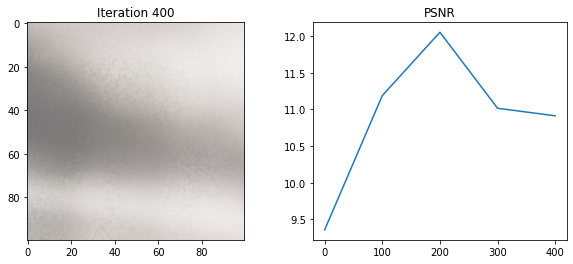

Loss: 0.06866558641195297


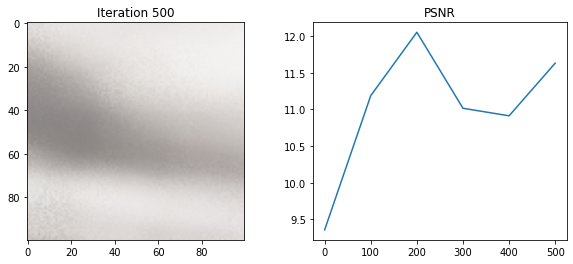

Loss: 0.06419096142053604


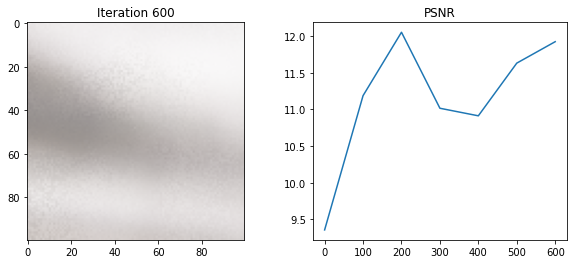

Loss: 0.06458684056997299


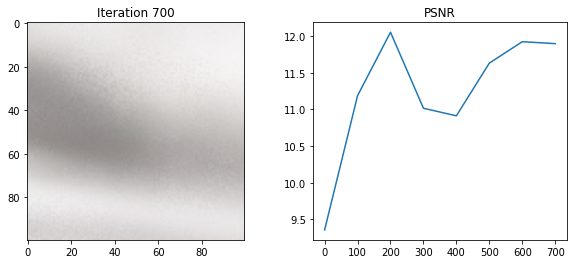

Loss: 0.07082319259643555


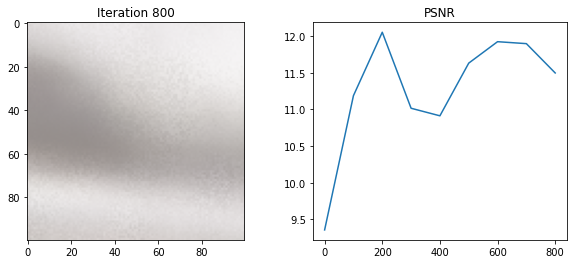

Loss: 0.0693173035979271


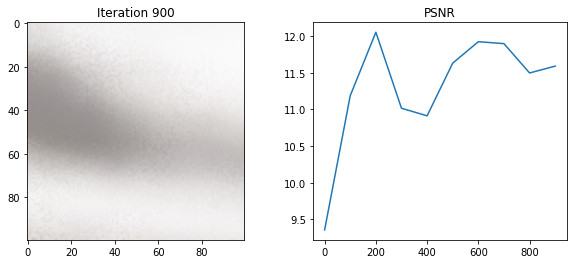

KeyboardInterrupt: ignored

In [36]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 10000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []
focal_length = 5*50

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [13]:
model = VeryTinyNerfModel().to(device)
model.load_state_dict(torch.load("/gdrive/My Drive/nerf_model.pt"))
model.eval()

VeryTinyNerfModel(
  (layer1): Linear(in_features=39, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [14]:
import torch.nn as nn


class Flatten(nn.Module):
    """
        Simple tensor flattening module
    """

    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    """
        Simple tensor unflattening module
    """

    def forward(self, input, size=64):
        return input.view(input.size(0), size, 1, 1)


class DENDecoder(nn.Module):
    """
        Decoder architecture for the density / concentration of the smoke.
    """

    def __init__(self, nz=100, ngf=100):
        super(DENDecoder, self).__init__()
        self.nc = 3

        self.main = nn.Sequential(
            nn.Linear(nz, 576),
            UnFlatten(),
            # input is Z, going into a convolution
            nn.ConvTranspose2d(64, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(True),
            #   (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(True),
            #   (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(True),
            #   (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(True),
            #   (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, self.nc, 4, 2, 1, bias=False),
            nn.LeakyReLU(True)
            #   (nc) x 64 x 64
        )

    def forward(self, x):
        for layer in self.main:
            # print(x.shape)
            x = layer(x)
        return x


class DENEncoder(nn.Module):
    """
        Encoder architecture for the density of the smoke.
    """

    def __init__(self, nz=100, ndf=100):
        super(DENEncoder, self).__init__()
        self.nc = 3
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 64, 4, 1, 0, bias=False),
            # finally we reduce to our desired latent space size
            Flatten(),
            nn.Linear(576, nz)
        )

    def forward(self, x):
        for layer in self.main:
            #print(x.shape)
            x = layer(x)
        return x


class DENDiscriminator(nn.Module):
    """
        The discriminator architecture for the DEN autoencoder
    """

    def __init__(self, nz=32, h_dim=128):
        super(DENDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        for layer in self.main:
            # print("input: ", x.shape, "with ", nz, h_dim)
            x = layer(x)
        return x


if __name__ == "__main__":
    # simple dimension debugging
    Q_sdf = DENEncoder()
    P_sdf = DENDecoder()

    x = torch.randn(4, 3, 100,100)
    z = Q_sdf(x)
    #y = P_sdf(z)
    #print(x.shape, z.shape, y.shape)

In [15]:
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-vazpdxkk
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-vazpdxkk
     |████████████████████████████████| 276kB 10.4MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.2.5-cp36-cp36m-linux_x86_64.whl size=11984705 sha256=c4b7570172269e7b90e34fa1650f8cd622f9c413971bc2d4a6c1a5871a6fe378
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4v8l2p0/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=8b38b2d6c879d5c68eeaa30165a31fd79f1ed7f966dc7eb2d933f9c3f86db1d2
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=d6c4b43953c4129e966ec118a3d7dbe1b145fa7d511b4943aca9b5199e38

In [17]:
import pytorch3d
from pytorch3d.transforms import random_rotation
from pytorch3d.renderer.cameras import look_at_rotation


In [36]:
translation = tform_cam2world[:, :3,3]
center = torch.mean(translation, dim=0).to(device)
diff = center - translation

n = torch.norm(diff, p=2, dim=1)
radius = torch.mean(n)

print(radius, center)


def get_new_pose(center, radius):
    """
    generates a new pose / perspective for the NeRF model
    """

    rot = random_rotation().to(device)
    unit_x = torch.tensor([1.,0.,0.]).to(device)
    new_t = center + rot @ unit_x

    #print(new_t)
    #print(new_t.shape, center.shape)
    #print(type(new_t), type(center))
    cam_rot = look_at_rotation(camera_position=new_t.unsqueeze(dim=0), 
                               at=center.unsqueeze(dim=0))
    print(cam_rot, "sss")

    transform = torch.zeros((4,4))#.to(device)
    
    transform[:3, :3] = cam_rot
    transform[3, :3] = new_t
    transform[3, 3] = 1
    #print(look_at_rotation(center))
    return transform

print(get_new_pose(center,radius))


tensor(3.1980, device='cuda:0') tensor([-0.3888,  0.0537,  2.2851], device='cuda:0')
tensor([[[-0.9990, -0.0119,  0.0440],
         [ 0.0000,  0.9656,  0.2601],
         [-0.0456,  0.2598, -0.9646]]]) sss
tensor([[-0.9990, -0.0119,  0.0440,  0.0000],
        [ 0.0000,  0.9656,  0.2601,  0.0000],
        [-0.0456,  0.2598, -0.9646,  0.0000],
        [-0.4329, -0.2064,  3.2497,  1.0000]])


tensor([[[-0.8131,  0.2893, -0.5051],
         [ 0.0000,  0.8678,  0.4969],
         [ 0.5821,  0.4041, -0.7056]]]) sss
True


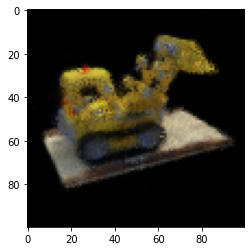

In [52]:
# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 10000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

new_pose = get_new_pose(center, radius).to(device)
print(new_pose.is_cuda)
predicted = run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world[40],
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encode, get_minibatches)

plt.imshow(predicted.detach().cpu().numpy())

In [53]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/camera_visualization.py
from camera_visualization import plot_camera_scene

--2020-08-28 21:03:29--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2335 (2.3K) [text/plain]
Saving to: ‘camera_visualization.py’

camera_visualizatio 100%[===================>]   2.28K  --.-KB/s    in 0s      

2020-08-28 21:03:29 (49.0 MB/s) - ‘camera_visualization.py’ saved [2335/2335]



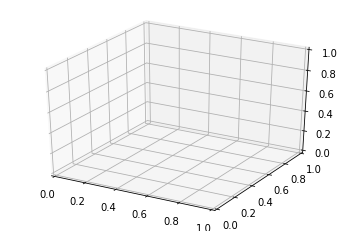

In [55]:


from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')